In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load in my spectral light curves
mydata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/allorbits_rawSpectralLightcurves.npz')
times = np.concatenate((mydata['orbit2_times'], mydata['orbit3_times'], mydata['orbit4_times']))
rawfluxes = np.concatenate((mydata['orbit2_flux'], mydata['orbit3_flux'], mydata['orbit4_flux']))
# the arrays read in as shape (Npoints, Nwaves) but code needs (Nwaves, Npoints), so swap the axes ...
rawfluxes = np.swapaxes(rawfluxes, 0, 1)
rawerrors = np.concatenate((mydata['orbit2_error'], mydata['orbit3_error'], mydata['orbit4_error']))
rawerrors = np.swapaxes(rawerrors, 0, 1)
scandirs = np.concatenate((mydata['orbit2_scandirs'], mydata['orbit3_scandirs'], mydata['orbit4_scandirs']))

t_visit = times - times[0]

# tsdata = np.load('./Transit_Spectra_NoFirst_Visit3.npz')
# times = tsdata['time']
# t_visit = times - times[0]
# rawfluxes = tsdata['flux']
# rawerrors = tsdata['error']
# scandirs = tsdata['scandir']
# #waves = tsdata['wavelengths']
    
# Pull out times [in day; MJD] of each orbit
orbit_ends = np.array([17, 34, 51])
orbit2times = times[:orbit_ends[0]]
orbit3times = times[orbit_ends[0] : orbit_ends[1]]
orbit4times = times[orbit_ends[1] : orbit_ends[2]]

# From above, compute time since beginning of orbit for each
tinorbit2 = orbit2times - orbit2times[0]
tinorbit3 = orbit3times - orbit3times[0]
tinorbit4 = orbit4times - orbit4times[0]
t_orbit = np.concatenate((tinorbit2, tinorbit3, tinorbit4))

fluxes = np.copy(rawfluxes)
errors = np.copy(rawerrors)
Nbins = rawfluxes.shape[0]
for wav in range(Nbins):
    # normalizing thomas'
    sd1_idxs = np.where(scandirs == 1.)[0]
    sd0_idxs = np.where(scandirs == 0.)[0]
    
    # if normalizing by max flux in second orbit:
#     orbit2_sd1 = rawfluxes[wav,:][sd1_idxs][:8]
#     orbit2_sd0 = rawfluxes[wav,:][sd0_idxs][:8]
#     normval1, normval0 = np.max(orbit2_sd1), np.max(orbit2_sd0)
    # if normalizing by median flux of whole visit
    normval1 = np.median(fluxes[wav, sd1_idxs])
    normval0 = np.median(fluxes[wav, sd0_idxs])
    
    fluxes[wav, sd1_idxs] /= normval1
    errors[wav, sd1_idxs] /= normval1
    fluxes[wav, sd0_idxs] /= normval0
    errors[wav, sd0_idxs] /= normval0

errors *= 10.0
    
Npoints = fluxes.shape[1]
Nwaves = fluxes.shape[0]

In [3]:
print('Average flux error = %d ppm'%(np.mean(errors*1.e6)))

Average flux error = 204 ppm


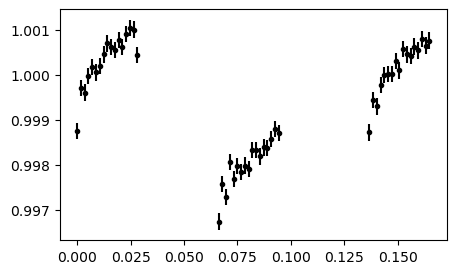

In [4]:
fig, ax = plt.subplots(figsize=(5,3))
#ax.scatter(t_orbit, fluxes[0,:])
ax.errorbar(t_visit, fluxes[0,:], errors[0,:], ls='None', ms=3, marker='o' ,c='black')
#ax.scatter(t_visit[17:34], fluxes[0,17:34], c='red')
plt.show()

In [5]:
##
# Defining my parameter arrays (inits, priors, etc)
# I'll fix all of the orbital parameters to values gotten from my broadband fitting
# Here, I'll only fit the transit depths and systematic parameters
# I should also look into using single systematics based on broadband fitting too
rprs_init, rprs_init_unc = 0.0439177, 0.00027693

# t0_fixed = 2458329.200100647 #2458329.201974941  # [day]
# P_fixed =  10. ** 0.780638562833854 #6.03447168385       # [day]
# a_fixed = 10. ** 1.1200598308963605 #13.4136             # [Rs]
# inc_fixed = (180. / np.pi) * np.arccos(np.fabs(0.06440772705532975)) #86.4225           # [degrees]
# ecc_fixed = 0.
# w_fixed = 90.
# u_fixed = [0.058, 0.349] #[0.33, 0.2]
t0_fixed = 2458329.201974941  # [day]
P_fixed =  6.03447168385       # [day]
a_fixed = 13.4136             # [Rs]
inc_fixed = 86.4225           # [degrees]
ecc_fixed = 0.
w_fixed = 90.
u_fixed = [0.058, 0.349] #[0.33, 0.2]

amplitude_o2_init, amperr_o2_init = 0.0022, 0.01
amplitude_o3_init, amperr_o3_init = 0.0012, 0.01
    
tau_o2_init, tauerr_o2_init = -0.007, 0.01
tau_o3_init, tauerr_o3_init = -0.005,0.01

slope_init, slopeerr_init = -0.0065, 0.01
intcpt_init, intcpterr_init =  1.0000+0.0011, 0.01

# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = t0_fixed     
InitParams.per = P_fixed
InitParams.a = a_fixed
InitParams.inc = inc_fixed
InitParams.rp = rprs_init
InitParams.ecc = ecc_fixed
InitParams.w = w_fixed
InitParams.limb_dark = 'quadratic'
InitParams.u = u_fixed
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [6]:
##
# Defining my astrophysical models

def transit(rprs, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = t0_fixed       # time of conjunction [days]
    P = P_fixed  # compute Period in [day]
    a = a_fixed  # compute a/Rstar
    inc = inc_fixed  # Compute inclination in [deg]
    ecc = ecc_fixed    # use these if assuming circular orbit
    omega = w_fixed
    rprstar = np.copy(rprs)
        
    # Set batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    params.limb_dark = 'quadratic'
    params.u = u_fixed
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve



##
# Defining my systematic models
def hook(theta):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude2 = theta[1]
    amplitude3 = theta[2]
    tau2 = theta[3]
    tau3 = theta[4]
    
    hookcurve = np.zeros(len(t_orbit))
    hookcurve[:17] = 1. - amplitude2*np.exp(t_orbit[:17]/tau2)
    hookcurve[17:] = 1. - amplitude3*np.exp(t_orbit[17:]/tau3)
    return hookcurve

def ramp(theta):
    # Visit-long linear model for flux in time
    slope = theta[5]
    intercept = theta[6]
    
    y = intercept + (slope*t_visit)
    return y

In [7]:
# # ramp model
# 		lc = Lightcurve(pars, data['time'], Section=FitParams['Section'], SpecNo=SpecNo, Telescope='HST', visit=visit)
# 		ramp = JustRamp(pars, data, visit, SpecNo=SpecNo)
# 	model = ramp * lc
# 	return model

# model = RampModel(pars, dataV1, 'v1', FitParams, SpecNo=j)
# 			if model[0] == -99: return -numpy.inf
# 			chiarr = ((dataV1['flux'][j] - model) ** 2. / dataV1['error'][j] ** 2.) + numpy.log(2. * math.pi * dataV1['error'][j] ** 2.)
# 			lnprobmodel += -0.5 * numpy.sum(chiarr)
            
# 	lnprobprior = 0.0
# 	for param in priors_to_apply['gaussian']:
# 		lnprobprior += -(pars[param] - priors[param][0]) ** 2. / (2 * priors[param][1] ** 2.) - numpy.log(
# 			math.sqrt(2 * priors[param][1] ** 2. * math.pi))

# 	lnprobtot = lnprobmodel + lnprobprior
# 	return lnprobtot



In [8]:
def logLikelihood(ydata, yerr, modely):
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    
    return lnL

def logPriors(theta):
    priors = mc_priors
    priorserr = mc_priorserr
    
    # Limits on certain parameters
    if not (0. <= theta[0] <= 1.): return -np.inf
    if (theta[1] > 0.01): return -np.inf
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            lnP += 0 #continue
        else:
            lnP += -(theta[i] - priorval) ** 2. / (2. * priorserr[i] ** 2.) - np.log(np.sqrt(2. * priorserr[i] **2. * np.pi))
            #-0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    return lnP

def lnPosterior(theta):
    
    prior_array = mc_priors
    priorerrs_array = mc_priorserr
    flux_array = mc_flux
    unc_array = mc_errs
        
    tran_model = transit(theta[0], BATMAN_initmodel)
    hook_model = hook(theta)
    ramp_model = ramp(theta)
    model = tran_model * hook_model * ramp_model
        
    lnlikelihood = logLikelihood(mc_flux, mc_errs, model)
    
#     # Compute and check priors
    lnPrior_value = logPriors(theta)
#     if not np.isfinite(lnPrior_value):
#         return -np.inf

    # Compute posterior
    lnPost = lnlikelihood + lnPrior_value
    
    if (np.isnan(lnPost)):
        return -np.inf
    else:
        return lnPost

In [9]:
res = {
    'spec0':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec1':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec2':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec3':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec4':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec5':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec6':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec7':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec8':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec9':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec10':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec11':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec12':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec13':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec14':{
        'fits': np.array([]),
        'errs': np.array([])
    }
}

In [10]:
Nburn = 5000
Nsteps = 4000


for wav in range(Nwaves):
    print('on bin ', wav)
    # set up initial values and priors
    theta_init = np.array([rprs_init, amplitude_o2_init, amplitude_o3_init, tau_o2_init, tau_o3_init, slope_init, intcpt_init])
    priorerrs = np.array([rprs_init_unc, amperr_o2_init, amperr_o3_init, tauerr_o2_init, tauerr_o3_init, slopeerr_init, intcpterr_init])
    # define mcmc global inputs
    mc_flux, mc_errs = fluxes[wav,:], errors[wav,:]
    mc_priors = np.array([np.inf, amplitude_o2_init, amplitude_o3_init, tau_o2_init, tau_o3_init, slope_init, intcpt_init])
    mc_priorserr = np.copy(priorerrs)
    # compute initial posterior
    lnPost_init = lnPosterior(theta_init)
    print(lnPost_init)
    
    # Setting up and initializing MCMC
    Ndimensions = len(theta_init)
    Nwalkers = 2*Ndimensions

    # Initializing walker positions
    pos = np.zeros((Nwalkers, Ndimensions))
    for i in range(Ndimensions):
        pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorerrs[i], Nwalkers)
    print('running burn-in')
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
        sampler.run_mcmc(pos, Nburn, progress=True);
        
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)
    burn = int(Nburn-100)
    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]

    burn_vals = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
    burn_err = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - burn_vals
    
    pos = np.zeros((Nwalkers, Ndimensions))
    for i in range(Ndimensions):
        pos[:,i] = burn_vals[i] + 0.5*np.random.normal(0., burn_err[i], Nwalkers)
    print('running mcmc')
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
        sampler.run_mcmc(pos, Nsteps, progress=True);\
        
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)

    burn = 0
    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]

    param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
    param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
    param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])
    gausserrs = np.mean((param_uperrs, param_loerrs), axis=0)
    
    depth_chain = flatsamples[:,0] ** 2.
    depth_fit = np.median(depth_chain)
    depth_uperr = np.percentile(depth_chain, 84) - depth_fit
    depth_loerr = depth_fit - np.percentile(depth_chain, 16)
    depth_err = np.mean((depth_uperr, depth_loerr))
    param_fits = np.append(param_fits, depth_fit)
    gausserrs = np.append(gausserrs, depth_err)
    
     # compute final posterior
    lnPost_fin = lnPosterior(param_fits)
    print(lnPost_fin)
    
    res['spec'+str(wav)]['fits'] = param_fits
    res['spec'+str(wav)]['errs'] = gausserrs

on bin  0
288.9754823388411
running burn-in


100%|██████████| 5000/5000 [00:07<00:00, 639.21it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 627.63it/s]

390.4932368525704
on bin  1
136.25135323283877
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 637.23it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 627.48it/s]

378.411372173825
on bin  2
284.08040371658126
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 631.00it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 630.81it/s]

373.929121060043
on bin  3
344.3652976375174
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 629.84it/s]


running mcmc


100%|██████████| 4000/4000 [00:06<00:00, 628.67it/s]

388.330117492498
on bin  4
321.96170910746594
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 625.60it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 631.53it/s]

384.08921469735697
on bin  5
364.3389527815586
running burn-in



100%|██████████| 5000/5000 [00:08<00:00, 621.04it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 631.09it/s]

389.72454682534374
on bin  6
369.36414695611734
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 629.57it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 631.79it/s]

394.96565184999616
on bin  7
341.99457996537745
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 625.25it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 622.00it/s]


393.7377491728812
on bin  8
367.3809985253156
running burn-in


100%|██████████| 5000/5000 [00:08<00:00, 622.30it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 632.38it/s]

388.94548147645065
on bin  9
343.19585841634336
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 631.73it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 629.96it/s]

384.56094354103004
on bin  10
307.5381229486525
running burn-in



100%|██████████| 5000/5000 [00:08<00:00, 624.45it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 630.29it/s]

381.1993272453038
on bin  11
340.057696195767
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 629.61it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 629.69it/s]

387.2699305542371
on bin  12
207.36181658727224
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 628.81it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 631.57it/s]

371.2374873361295
on bin  13
296.1621316547497
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 628.21it/s]


running mcmc


100%|██████████| 4000/4000 [00:06<00:00, 628.31it/s]

382.52201902172266
on bin  14
170.8162545422124
running burn-in



100%|██████████| 5000/5000 [00:07<00:00, 633.04it/s]

running mcmc



100%|██████████| 4000/4000 [00:06<00:00, 631.74it/s]

362.0565958007056


In [11]:
#res

In [12]:
depths = np.zeros(Nwaves)
deptherrs = np.copy(depths)
for wav in range(Nwaves):
    rprs = res['spec'+str(wav)]['fits'][0]
    err = res['spec'+str(wav)]['errs'][0]
    
    depth = rprs**2
    derr = depth*(err/rprs)*np.sqrt(2)
    depths[wav] = depth
    deptherrs[wav] = derr
    
    print('Wavelength bin %d'%(wav))
    print('Depth = %d +/- %d ppm'%(depth*1.e6, derr*1.e6))
print('\n')
print('Average depth error = %d ppm'%(np.mean(deptherrs*1.e6)))

Wavelength bin 0
Depth = 2344 +/- 121 ppm
Wavelength bin 1
Depth = 2651 +/- 177 ppm
Wavelength bin 2
Depth = 2294 +/- 185 ppm
Wavelength bin 3
Depth = 1609 +/- 45 ppm
Wavelength bin 4
Depth = 2400 +/- 114 ppm
Wavelength bin 5
Depth = 1633 +/- 55 ppm
Wavelength bin 6
Depth = 1577 +/- 52 ppm
Wavelength bin 7
Depth = 1470 +/- 45 ppm
Wavelength bin 8
Depth = 1871 +/- 59 ppm
Wavelength bin 9
Depth = 1359 +/- 56 ppm
Wavelength bin 10
Depth = 1259 +/- 54 ppm
Wavelength bin 11
Depth = 1530 +/- 49 ppm
Wavelength bin 12
Depth = 867 +/- 54 ppm
Wavelength bin 13
Depth = 1106 +/- 58 ppm
Wavelength bin 14
Depth = 632 +/- 59 ppm


Average depth error = 79 ppm


In [13]:
%store -r tp_md_depths
%store -r tp_md_deptherrs

In [14]:
for wav in range(Nwaves):
    print('Wavelength bin %d'%(wav))
    print('Depth = %d +/- %d ppm'%(tp_md_depths[wav]*1.e6, tp_md_deptherrs[wav]*1.e6))

print('\n')
print('Average depth error = %d ppm'%(np.mean(tp_md_deptherrs*1.e6)))    

Wavelength bin 0
Depth = 2407 +/- 194 ppm
Wavelength bin 1
Depth = 2596 +/- 262 ppm
Wavelength bin 2
Depth = 2296 +/- 245 ppm
Wavelength bin 3
Depth = 1644 +/- 63 ppm
Wavelength bin 4
Depth = 2497 +/- 184 ppm
Wavelength bin 5
Depth = 1667 +/- 89 ppm
Wavelength bin 6
Depth = 1612 +/- 77 ppm
Wavelength bin 7
Depth = 1508 +/- 64 ppm
Wavelength bin 8
Depth = 1931 +/- 100 ppm
Wavelength bin 9
Depth = 1400 +/- 82 ppm
Wavelength bin 10
Depth = 1291 +/- 79 ppm
Wavelength bin 11
Depth = 1578 +/- 74 ppm
Wavelength bin 12
Depth = 897 +/- 85 ppm
Wavelength bin 13
Depth = 1129 +/- 83 ppm
Wavelength bin 14
Depth = 655 +/- 91 ppm


Average depth error = 118 ppm


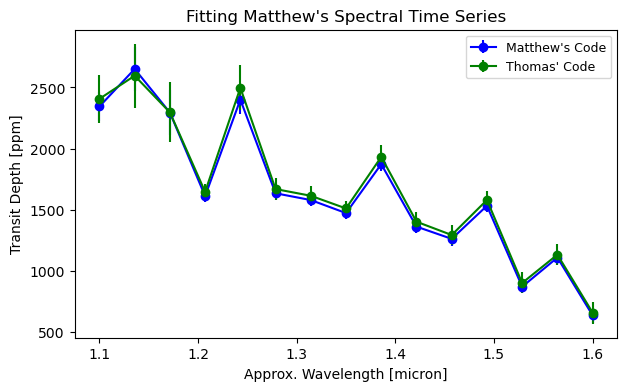

In [15]:
fig, ax = plt.subplots(figsize=(7,4))
waves = np.linspace(1.1, 1.6, Nwaves)
ax.set_title("Fitting Matthew's Spectral Time Series")
ax.errorbar(waves, depths*1.e6, yerr=deptherrs*1.e6, c='blue', marker='o', label="Matthew's Code")
ax.errorbar(waves, tp_md_depths*1.e6, yerr=tp_md_deptherrs*1.e6, c='green', marker='o', label="Thomas' Code")
ax.legend(loc='upper right', fontsize=9)
ax.set_xlabel('Approx. Wavelength [micron]')
ax.set_ylabel('Transit Depth [ppm]')
plt.show()

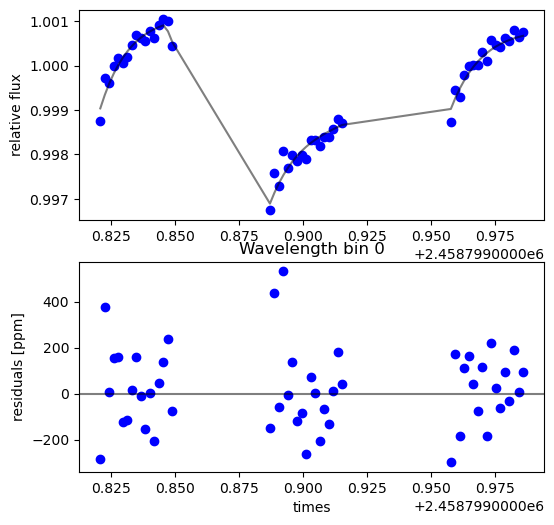

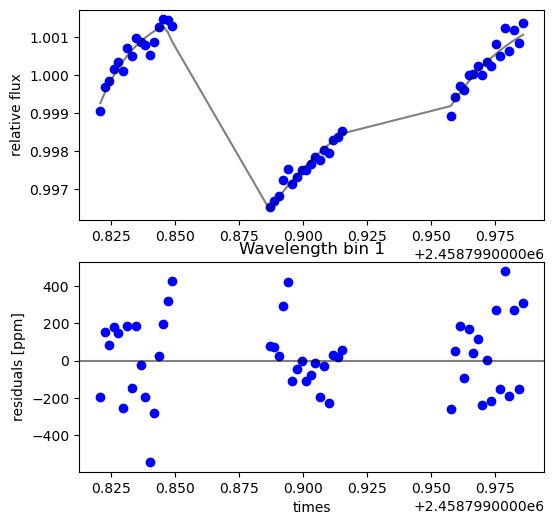

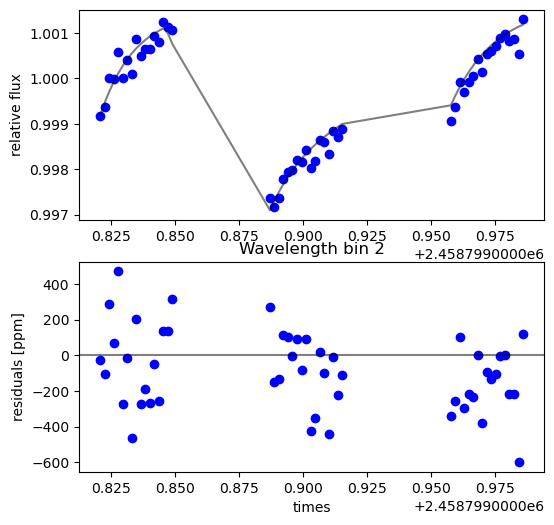

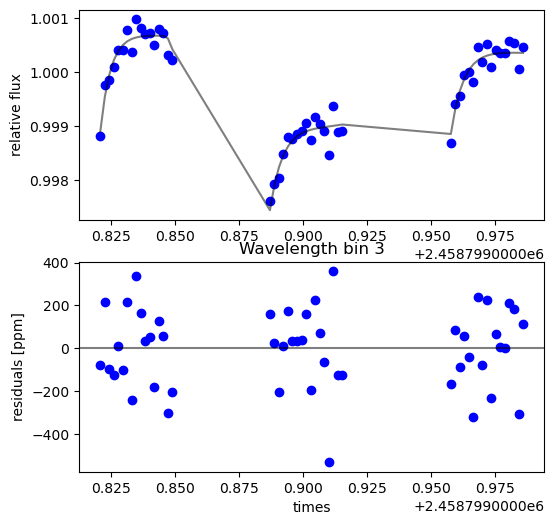

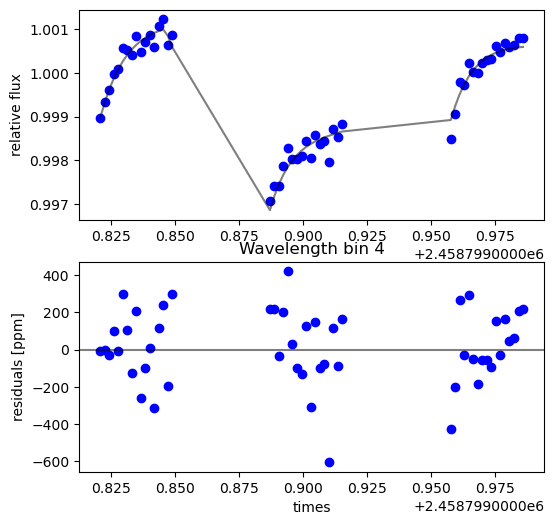

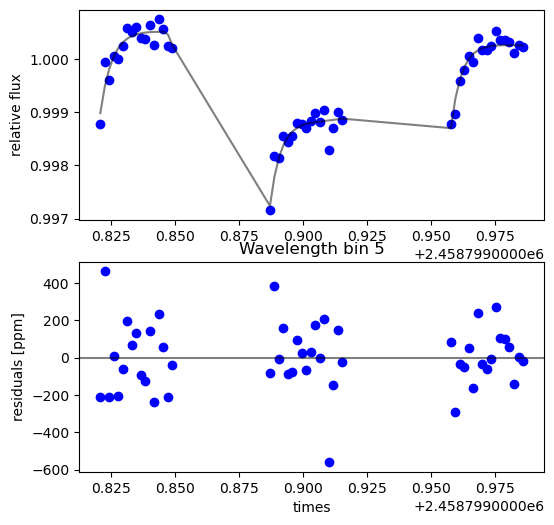

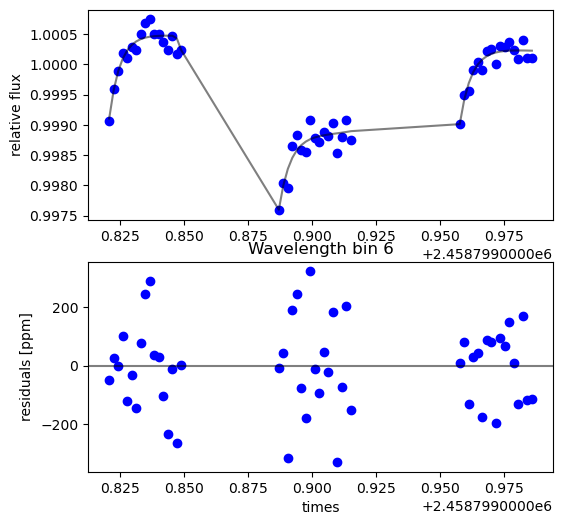

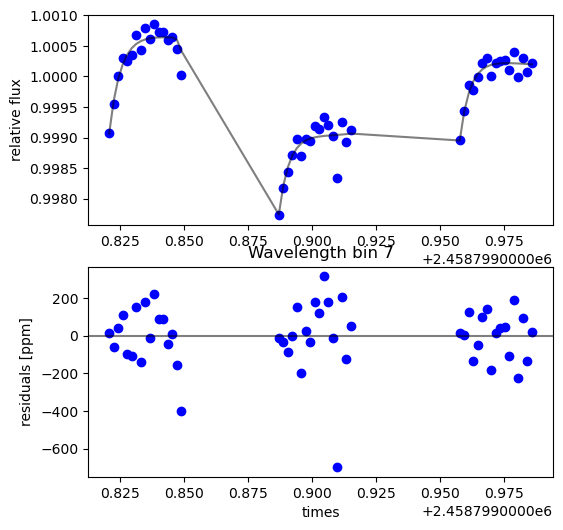

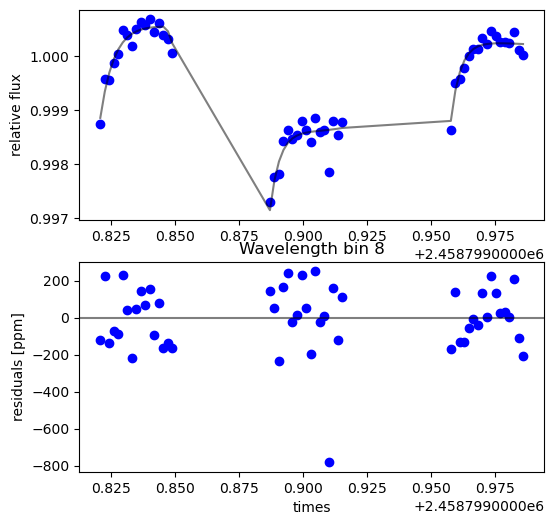

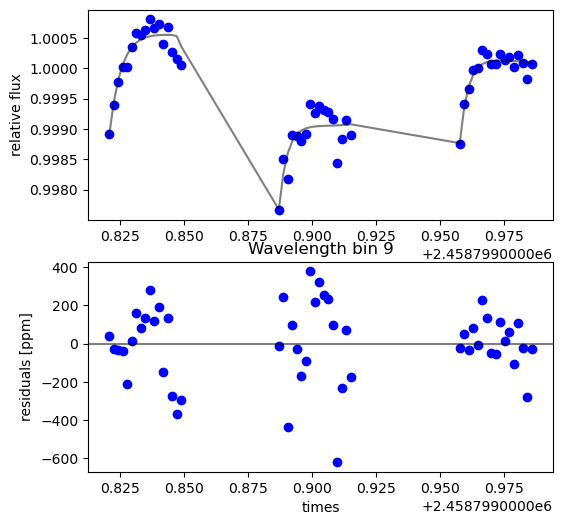

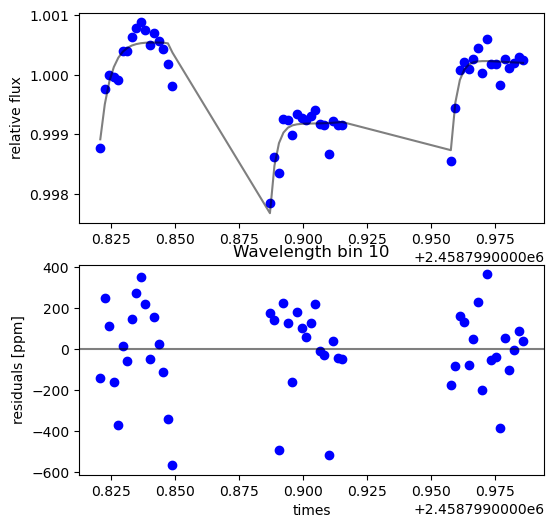

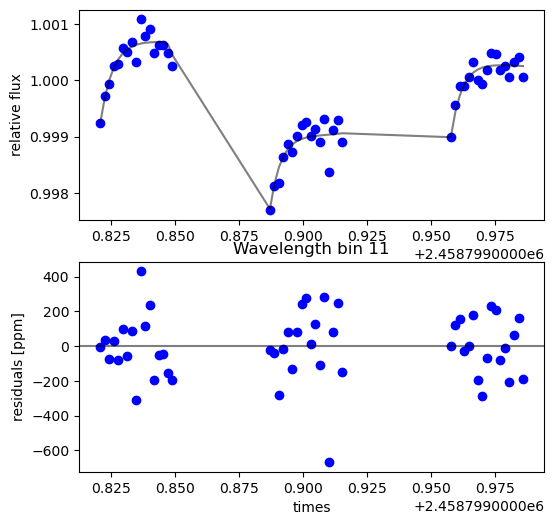

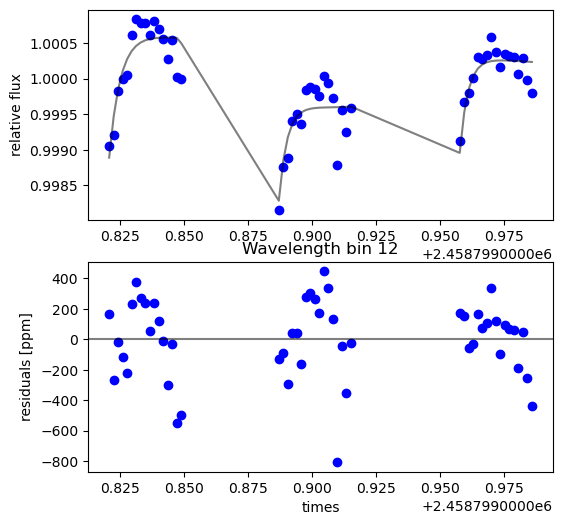

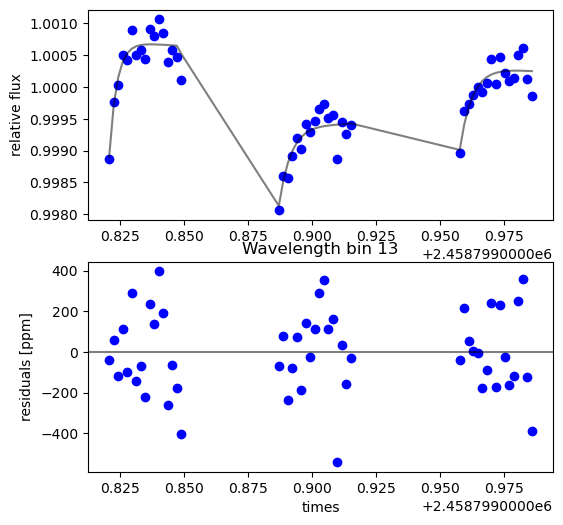

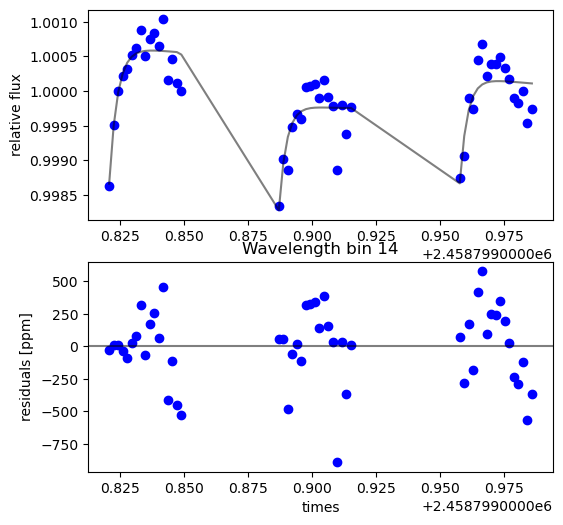

In [16]:
# Plotting raw light curves
for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_initmodel)
    hoo = hook(params)
    ram = ramp(params)
    model = tran * hoo * ram
    resids = fluxes[wav, :] - model
    
    fig, ax = plt.subplots(figsize=(6,6), nrows=2)
    # plotting the flux data and model
    ax[0].plot(times, model, c='black', alpha=0.5)
    ax[0].scatter(times, fluxes[wav,:], c='blue')
    ax[0].set_ylabel('relative flux')
    # plotting the residuals
    ax[1].axhline(0., c='black', alpha=0.5)
    ax[1].scatter(times, resids*1.e6, c='blue')
    ax[1].set_ylabel('residuals [ppm]')
    ax[1].set_xlabel('times')
    plt.title('Wavelength bin %d'%(wav))
    plt.show()

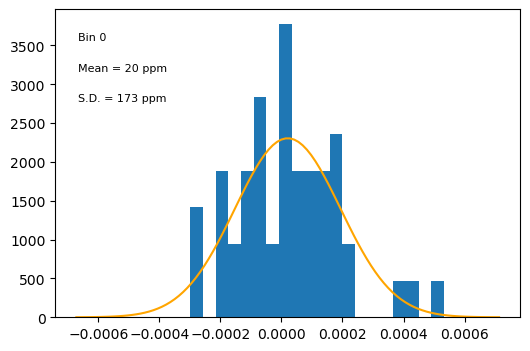

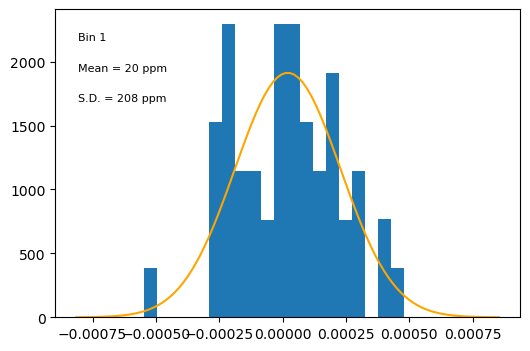

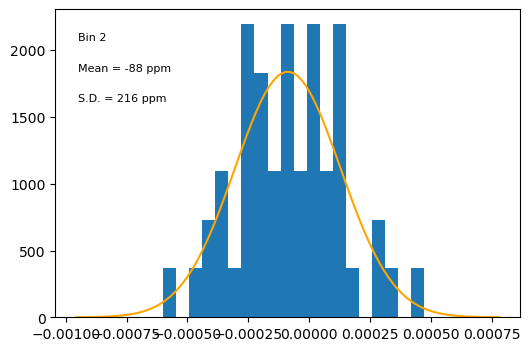

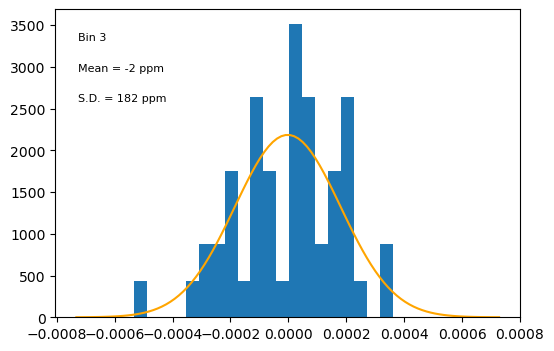

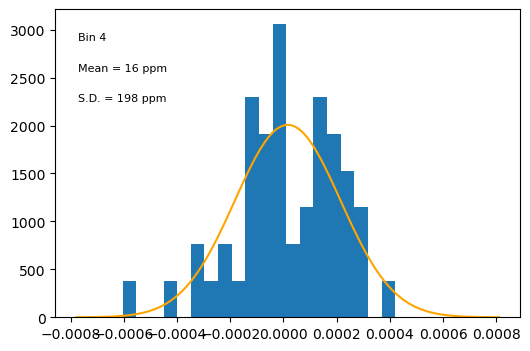

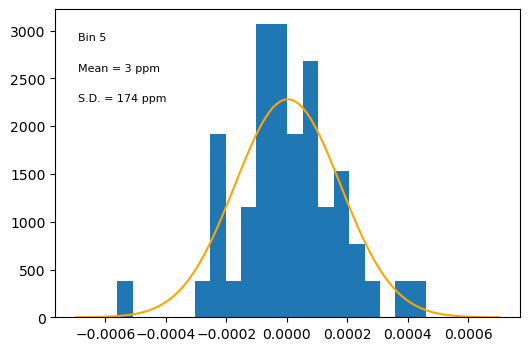

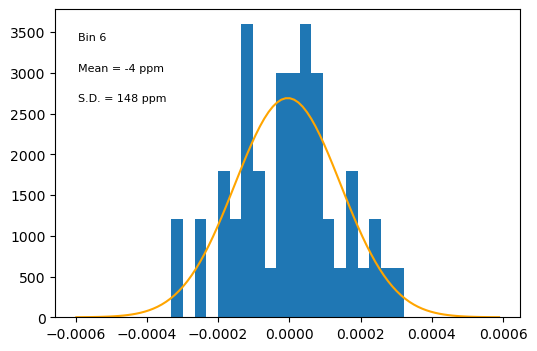

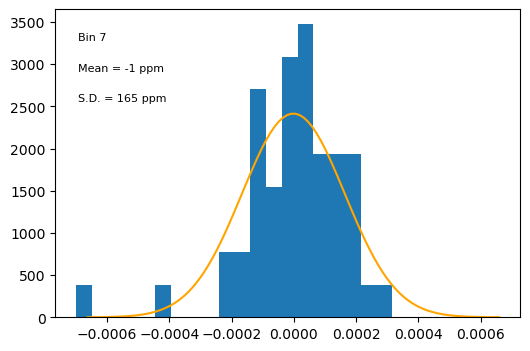

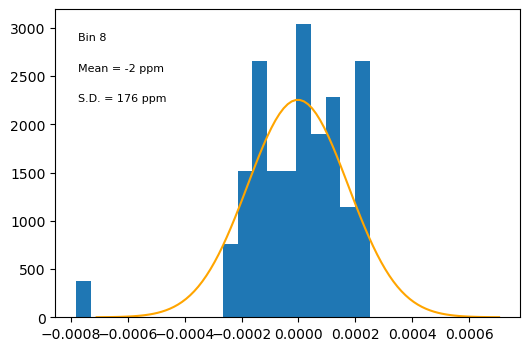

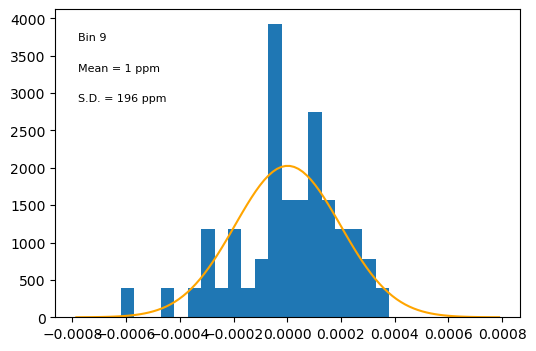

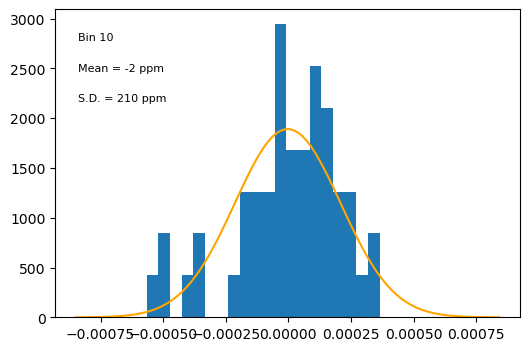

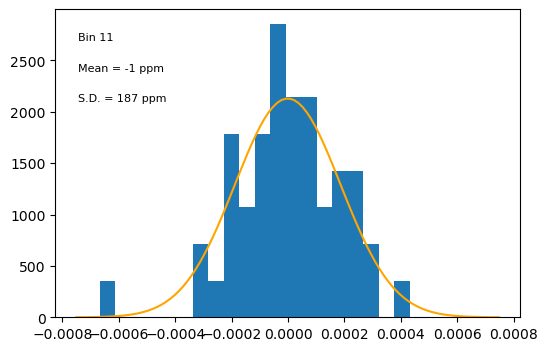

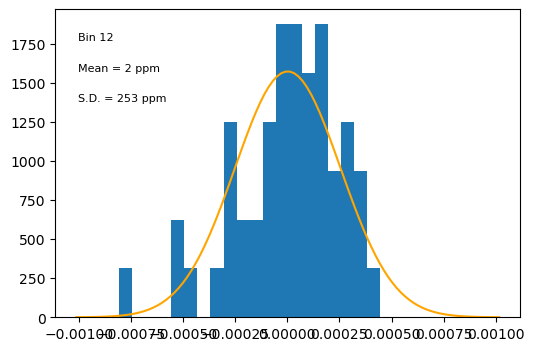

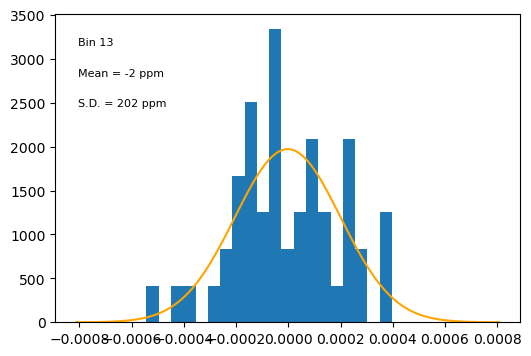

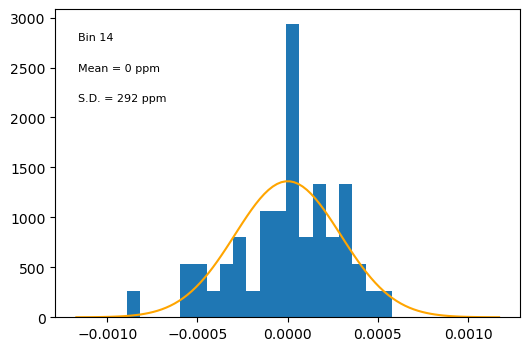

In [17]:
# plotting and fitting the residuals
residual_sd_vals = np.zeros(Nwaves)
for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_initmodel)
    hoo = hook(params)
    ram = ramp(params)
    model = tran * hoo * ram
    resids = fluxes[wav, :] - model
    
    mu, sd = norm.fit(resids)
    residual_sd_vals[wav] = sd
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(resids, bins=20, density=True)
    xpdf = np.linspace((mu-4.*sd), (mu+4.*sd), 100)
    ypdf = norm.pdf(xpdf, mu, sd)
    ax.plot(xpdf, ypdf, c='orange')
    ax.text(0.05, 0.9, 'Bin %d'%(wav), c='black', fontsize=8, transform=ax.transAxes)
    ax.text(0.05, 0.8, 'Mean = %d ppm'%(mu*1.e6), c='black', fontsize=8, transform=ax.transAxes)
    ax.text(0.05, 0.7, 'S.D. = %d ppm'%(sd*1.e6), c='black', fontsize=8, transform=ax.transAxes)
    plt.show()
    
    
    
#     fig, ax = plt.subplots(figsize=(6,6), nrows=2)
#     # plotting the flux data and model
#     ax[0].plot(times, model, c='black', alpha=0.5)
#     ax[0].scatter(times, fluxes[wav,:], c='blue')
#     ax[0].set_ylabel('relative flux')
#     # plotting the residuals
#     ax[1].axhline(0., c='black', alpha=0.5)
#     ax[1].scatter(times, resids*1.e6, c='blue')
#     ax[1].set_ylabel('residuals [ppm]')
#     ax[1].set_xlabel('times')
#     plt.show()

In [18]:
resid_level = np.mean(residual_sd_vals)
print('Residual level = %d ppm'%(resid_level*1.e6))

Residual level = 199 ppm


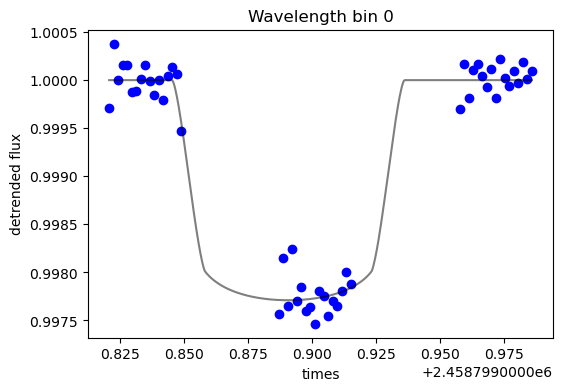

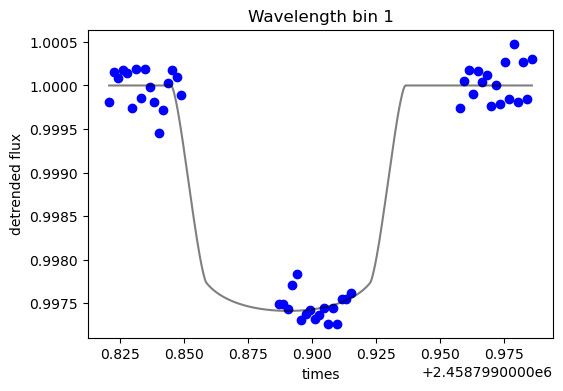

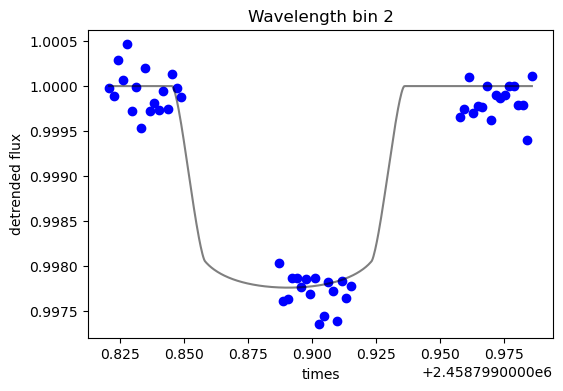

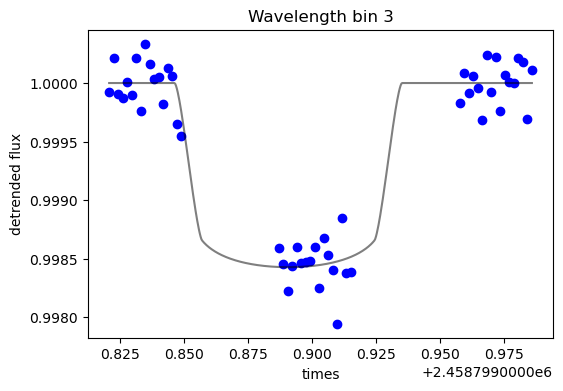

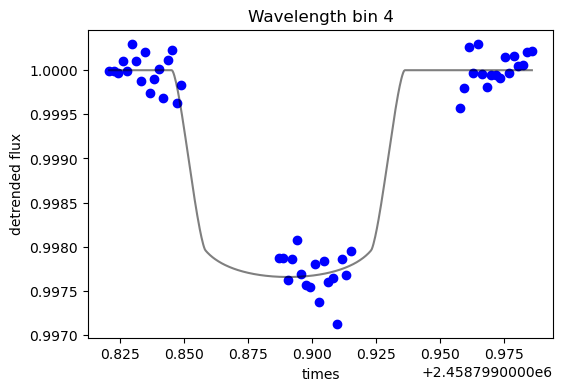

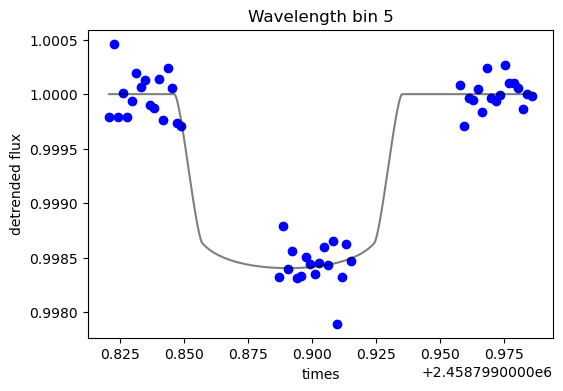

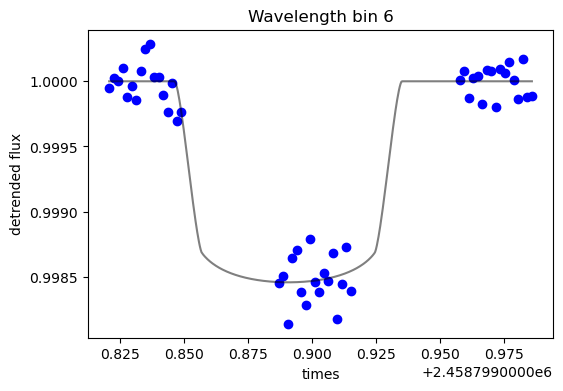

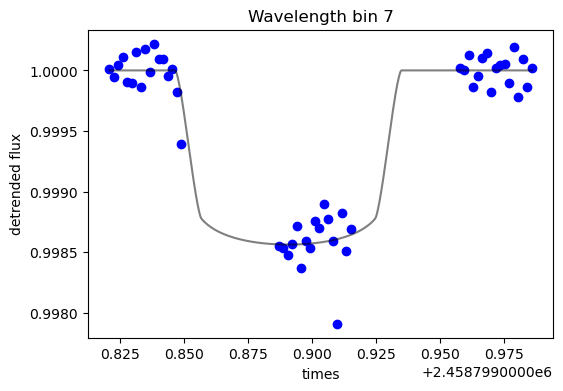

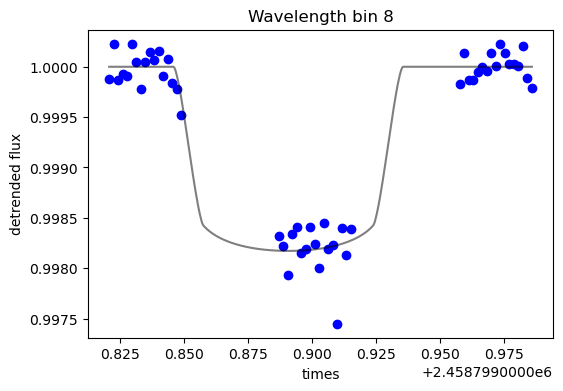

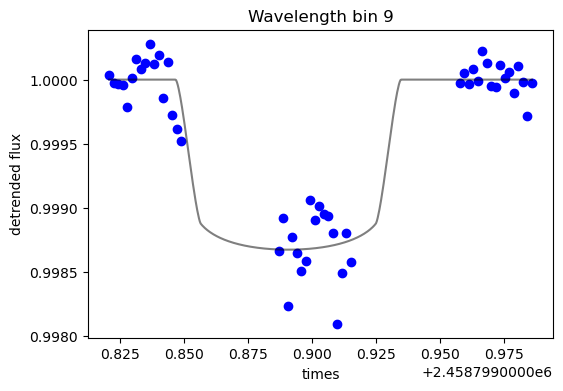

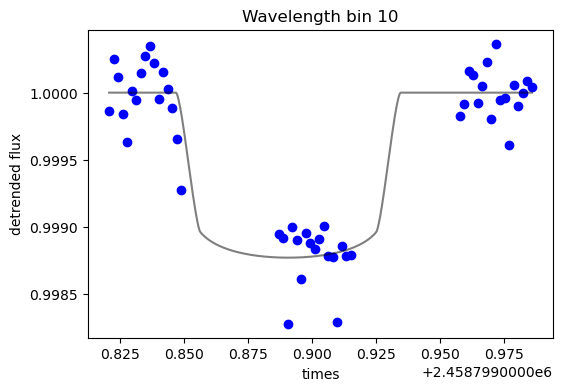

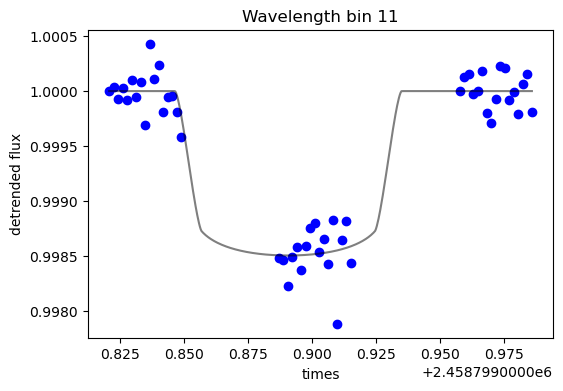

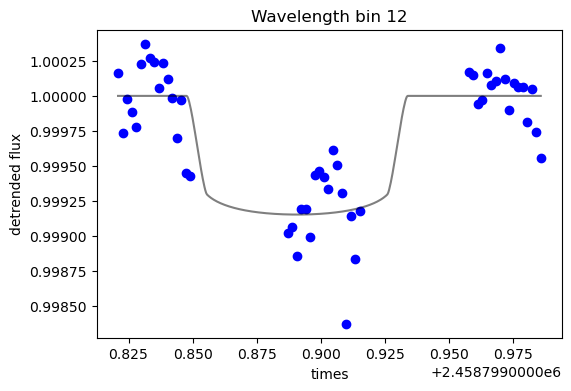

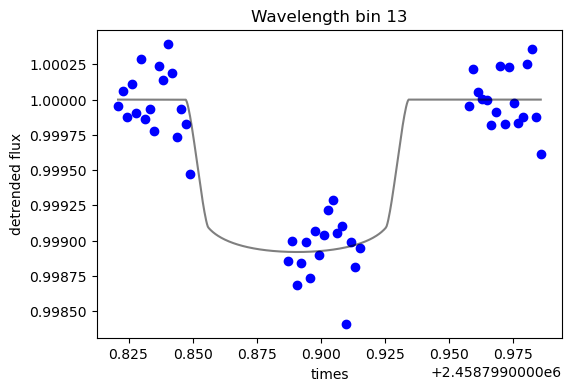

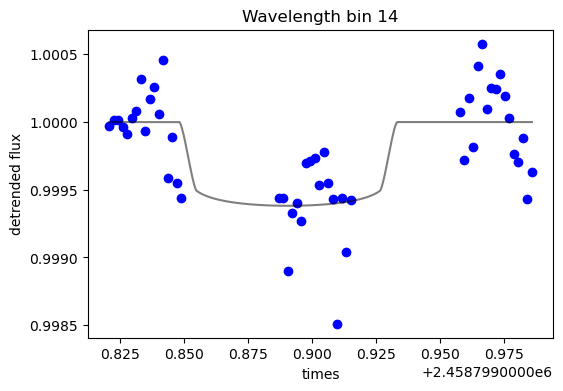

In [19]:
# Plotting detrended light curves
# Initializing the BATMAN model
PlottingParams = batman.TransitParams()
PlottingParams.t0 = t0_fixed     
PlottingParams.per = P_fixed
PlottingParams.a = a_fixed
PlottingParams.inc = inc_fixed
PlottingParams.rp = rprs_init
PlottingParams.ecc = ecc_fixed
PlottingParams.w = w_fixed
PlottingParams.limb_dark = 'quadratic'
PlottingParams.u = u_fixed
times_for_plotting = np.linspace(times[0], times[-1], 500)
BATMAN_plotmodel = batman.TransitModel(PlottingParams, times_for_plotting)

for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_plotmodel)
    hoo = hook(params)
    ram = ramp(params)
    systematics = hoo * ram
    det_flux = fluxes[wav,:] / systematics
    
    #model = tran * hoo * ram
    #resids = fluxes[wav, :] - model
    
    fig, ax = plt.subplots(figsize=(6,4))
    # plotting the flux data and model
    ax.plot(times_for_plotting, tran, c='black', alpha=0.5)
    ax.scatter(times, det_flux, c='blue')
    ax.set_ylabel('detrended flux')
    ax.set_xlabel('times')
    plt.title('Wavelength bin %d'%(wav))
    plt.show()